In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayaroshevskiy/downsampled-imagenet-64x64")


print("Path to dataset files:", path)

Path to dataset files: /home/varga/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1


In [2]:
path

'/home/varga/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1'

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from PIL import Image
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pickle


In [4]:
# Configuration
PATCH_SIZE = 4
FRAGMENTS_PER_IMAGE = 16
EMBED_DIM = 256
BATCH_SIZE = 10
EPOCHS = 10
LR = 1e-3
IMAGE_SIZE = 64
# cuda or mps or cpu
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_path = Path(path)/'train_64x64'/'train_64x64'
test_path = Path(path)/'valid_64x64/valid_64x64'
train_dataset_p = "tr_dataset.pt"
test_dataset_p = "te_dataset.pt"


In [6]:
from image_toolkit.data_processor import FragmentDataset

if Path(train_dataset_p).exists() and Path(test_dataset_p).exists():
    train_dataset = pickle.load(open(train_dataset_p, "rb"))
    test_dataset = pickle.load(open(test_dataset_p, "rb"))
else:
    test_dataset = FragmentDataset(test_path,limit=1000)

    pickle.dump(test_dataset, open(test_dataset_p, "wb"))
    train_dataset = FragmentDataset(train_path,limit=20000)
    pickle.dump(train_dataset, open(train_dataset_p, "wb"))

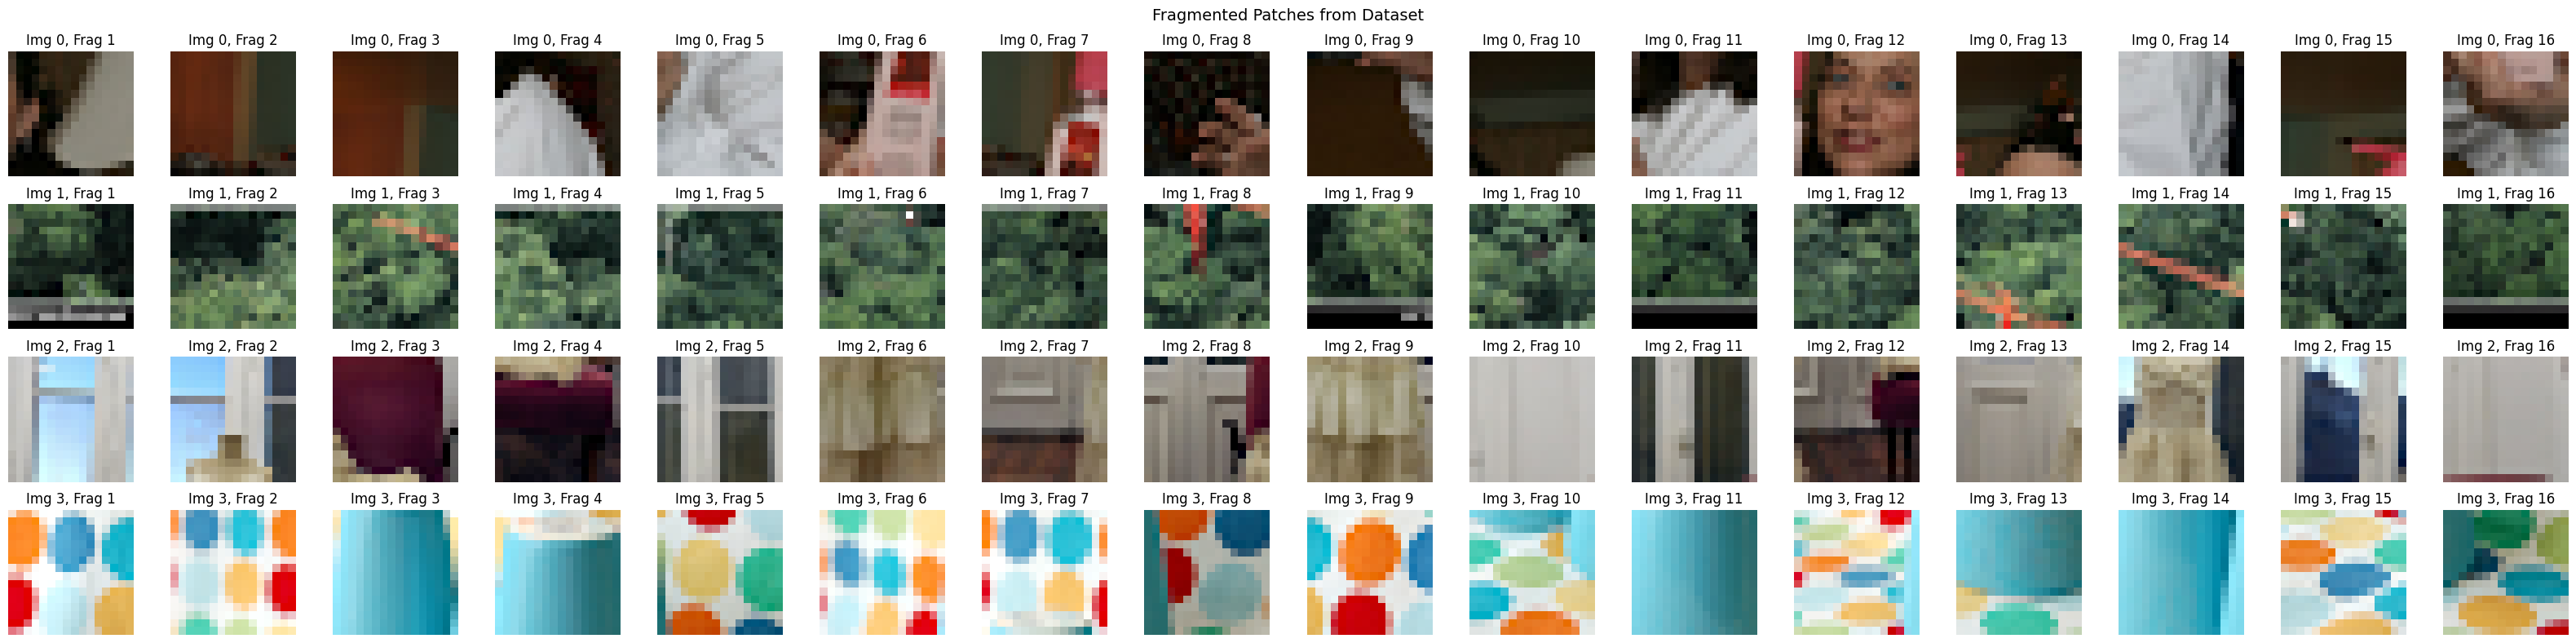

In [7]:
import matplotlib.pyplot as plt

# Visualise a few examples from the dataset
fig, axes = plt.subplots(4, FRAGMENTS_PER_IMAGE, figsize=(FRAGMENTS_PER_IMAGE * 2, 8))

for i in range(4):
    fragments, idx = train_dataset[i]
    for j in range(FRAGMENTS_PER_IMAGE):
        img = fragments[j].permute(1, 2, 0).numpy()  # CHW to HWC
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"Img {idx}, Frag {j+1}")

plt.suptitle("Fragmented Patches from Dataset", fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
import torchvision


class SimCLRProjectionHead(nn.Module):
    def __init__(self, input_dim=512, projection_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_dim, projection_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class SimCLRModel(nn.Module):
    def __init__(self, base_model='resnet18', projection_dim=128):
        super().__init__()
        self.encoder = models.resnet18(weights='IMAGENET1K_V1')
        self.encoder.fc = nn.Identity()
        self.projection_head = SimCLRProjectionHead(input_dim=512, projection_dim=projection_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

class GlobalRelationTransformer(nn.Module):
    def __init__(self, embed_dim=128, patch_c=3, patch_h=4, patch_w=4, num_heads=4, num_layers=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(patch_c, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * patch_h * patch_w, embed_dim)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.projector = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        # x: [B*N, C, H, W] — fully shuffled
        z = self.encoder(x)  # [B*N, D]
        z = z.unsqueeze(0)   # [1, B*N, D] for Transformer
        z = self.transformer(z)  # [1, B*N, D]
        z = z.squeeze(0)     # [B*N, D]
        return self.projector(z)



class ResNetTransformer(nn.Module):
    def __init__(self, embed_dim=128, transformer_layers=3, num_heads=4):
        super().__init__()

        # ResNet backbone (truncate final layer)
        backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(backbone.children())[:-2])  # output: [B, 512, H', W']
        self.fc = nn.Linear(512, embed_dim)  # reduce to desired dim

        self.pos_embed = nn.Parameter(torch.randn(1, 1024, embed_dim))  # max 1024 patches
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        self.projector = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):

        feat = self.encoder(x)  # [B*N, 512, H', W']
        #print("feat ", feat.shape)
        feat = F.adaptive_avg_pool2d(feat, (1, 1)).squeeze(-1).squeeze(-1)  # [B*N, 512]
        #print("feat ", feat.shape)
        z = self.fc(feat)  # [B*N, embed_dim]
        #print("z ", z.shape)

        # Add position encoding
        z = z.unsqueeze(0)  # [1, B*N, D]
        #z = z + self.pos_embed[:, :z.size(1), :]  # make sure it's added correctly: [1, B*N, D]

        z = self.transformer(z)  # [1, B*N, D]
        z = z.squeeze(0)  # [B*N, D]
        return self.projector(z)  # [B*N, D



In [9]:
dataloader_train = DataLoader(train_dataset, batch_size=10, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [10]:
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.cluster import KMeans

# Now safe to import sklearn/hdbscan/etc
from sklearn.metrics import adjusted_rand_score




In [ ]:
from image_toolkit.nets import GATPatchCluster, create_patch_graph
from sklearn.cluster import KMeans




import torch
import torch.nn as nn
import torchvision.models as models
from torch_geometric.nn import GATConv




# Hyperparameters
EPOCHS = 100
LR = 1e-4
#model = SimCLRModel(projection_dim=256).to(DEVICE)
model = GATPatchCluster(device=DEVICE,embed_dim=128).to(DEVICE)
#model = GlobalRelationTransformer(embed_dim=EMBED_DIM).to(DEVICE)
#model = ResNetTransformer(transformer_layers=1,num_heads=1,embed_dim=EMBED_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max', factor=0.5, patience=5)


model.train_model(dataloader_train,
                  dataloader_test,
                  optimizer,
                  lr_scheduler,
                  epochs=100,
                  device=DEVICE,
                  top_k=5,temp=0.35
                  )


#



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.20it/s]


Epoch [1/100], Loss: 4.4577
Epoch [1/100], ARI: 0.4115
current learning rate:  [0.0001]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:42<00:00, 19.53it/s]


Epoch [2/100], Loss: 4.2335
Epoch [2/100], ARI: 0.4370
current learning rate:  [0.0001]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:21<00:00, 14.12it/s]


Epoch [3/100], Loss: 4.1592
Epoch [3/100], ARI: 0.4534
current learning rate:  [0.0001]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:55<00:00, 35.87it/s]


Epoch [4/100], Loss: 4.1189
Epoch [4/100], ARI: 0.4668
current learning rate:  [0.0001]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1403/2000 [00:35<00:17, 33.42it/s]

🧠 Suggestions to Improve Clustering

1. Improve Training Signal
	•	Use a stronger contrastive loss, like NT-Xent (from SimCLR), with temperature scaling and softmax.
	•	Include hard negatives instead of random ones.
	•	Increase EPOCHS (50+), and possibly reduce learning rate gradually.

2. Embed More Patch Context
	•	Use larger patches or positional encoding to capture more spatial cues.
	•	Consider a Transformer or CNN with global receptive field.

3. More Patches per Image
	•	More fragment pairs during training allow the model to learn more consistent representations per source image.

4. Clustering Setup
	•	Try tuning min_cluster_size in HDBSCAN.
	•	Alternatively, try KMeans (if you roughly know the number of source images).

In [ ]:
# now i want to debug

batch, idx= next(iter(dataloader_train))


images1 = batch[0]
print(images1.shape)
images2 = batch[1]

# now compute the embeddings
model.eval()
with torch.no_grad():
    initial_embeddings = model.encoder(images1.to(DEVICE)).mean(dim=[2,3])
    edge_index = create_patch_graph(initial_embeddings, top_k=5).to(DEVICE)

    

        # Forward pass
    embeddings1 = model(images1.to(DEVICE),edge_index)
    initial_embeddings = model.encoder(images2.to(DEVICE)).mean(dim=[2,3])
    edge_index = create_patch_graph(initial_embeddings, top_k=5).to(DEVICE)
    embeddings2 = model(images2.to(DEVICE),edge_index)
    # compute cosine similarity of embeddings
    print("embeddings ", embeddings1.shape)
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings1[2].unsqueeze(0))


    print("sim 0 vs 1:", sim.item())
    sim = F.cosine_similarity(embeddings1[0].unsqueeze(0), embeddings2[6].unsqueeze(0))
    print("sim 0 vs 2:", sim.item())




In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm

# Reduce number of samples to avoid OOM
MAX_IMAGES = 4  # use fewer if needed
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for i, (batch, labels) in enumerate(dataloader_train):
        if len(all_labels) >= MAX_IMAGES * batch.size(1):
            break
        B, N, C, H, W = batch.shape
        print(B , N)
        batch = batch.view(B * N, C, H, W).to(DEVICE)
        initial_embeddings = model.encoder(batch).mean(dim=[2,3])
        edge_index = create_patch_graph(initial_embeddings, top_k=5).to(DEVICE)
        emb = model(batch,edge_index).cpu()
        all_embeddings.append(emb)
        all_labels.extend([i] * emb.size(0))

# Combine
embeddings = torch.cat(all_embeddings).numpy()
labels = all_labels[:len(embeddings)]

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(embeddings)

# KMeans (optional)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=clusters, palette="tab20", s=10, legend=False)
plt.title("t-SNE of Patch Embeddings (Clustered)")
plt.tight_layout()
plt.show()

In [ ]:
import torch
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure model is in evaluation mode
model.eval()

# Storage for embeddings and labels
subset_embeddings = []
subset_labels = []

MAX_SAMPLES = 400  # or reduce if it's too slow

with torch.no_grad():
    for fragments, labels in tqdm(dataloader):
        fragments = fragments.to(DEVICE)

        # Collect until max sample limit
        if len(subset_labels) >= MAX_SAMPLES:
            break

        embeddings = model(fragments)
        subset_embeddings.append(embeddings.cpu())
        subset_labels.extend(labels.cpu().numpy())

        if len(subset_labels) >= MAX_SAMPLES:
            break

# Convert to numpy
embeddings = torch.cat(subset_embeddings, dim=0).numpy()
subset_labels = subset_labels[:MAX_SAMPLES]  # in case we went over

# --- Re-encode labels to 0 ... N-1 ---
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(subset_labels)

# --- Run t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# --- Plot ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=labels_encoded, cmap="tab20", s=10
)
plt.title("t-SNE of Fragment Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(scatter, label="Encoded Image Index")
plt.tight_layout()
plt.show()

In [ ]:
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch, clases in tqdm(dataloader_train):
        B, N, C, H, W = batch.shape
        batch = batch.view(B*N,C,H,W).to(DEVICE)
        labels = torch.arange(B).repeat_interleave(N)

        # shuffle batch patches and labels
        idx = torch.randperm(B*N)
        batch = batch[idx]
        labels = labels[idx]
        print("labels ", labels)

        # Get all fragment embeddings: output is [B, N, D]
        all_embeddings = model(batch)
        print("all_embeddings ", all_embeddings.shape)

        # Randomly select 2 different fragments per image → z1 and z2

        # here shoud be z1 and z2 which are selecred from all_embeddings that z1[i] and z2[i] are from the same image


        z1 = torch.stack([all_embeddings[i, idx1[i]] for i in range(B)])
        z2 = torch.stack([all_embeddings[i, idx2[i]] for i in range(B)])
       #print("z1 ", z1.shape)
        # Compute contrastive loss
        loss = simple_contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader_train)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

    # Validation clustering
    model.eval()
    with torch.no_grad():
        avg_ari = evaluate_clustering_on_validation(dataloader_test, model)
        print(f"Epoch [{epoch + 1}/{EPOCHS}], ARI: {avg_ari:.4f}")
        lr_scheduler.step(avg_ari)
        print("Current LR:", lr_scheduler.get_last_lr())

In [ ]:
# Training loop


In [ ]:
!pip install torch_geometric